# Quantum Newton Raphson on Net0 with HHL linear solver

In this example, we use the HHL solver to drive the Newton-Raphson algorithm to obtain the pressure and flow rate of a small network, Net0:

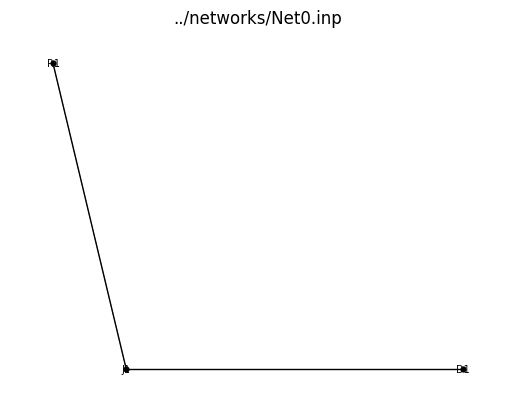

<Axes: title={'center': '../networks/Net0.inp'}>

In [ ]:
import os
import wntr
import wntr_quantum

# if not done in shell, define the environment variable here
# os.environ["EPANET_TMP"] = a directory where you have write access
# os.environ["EPANET_QUANTUM"] = the location of the EPANET source code

# set up network model
inp_file = "../networks/Net0.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


In [7]:
# define the classical EPANET simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

(name         J1         D1            R1
 0     29.647692  19.167677 -9.338379e-07
 3600  29.647692  19.167677 -9.338379e-07,
 name    P1    P2
 0     0.05  0.05
 3600  0.05  0.05)

### Solve water network with `QuantumEpanetSimulator` and HHL

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [6]:
import numpy as np
from qiskit.primitives import Estimator
from wntr_quantum.linear_solver import HHL_SOLVER
from utils import compare_results 

n_qubits = 1
estimator = Estimator()

linear_solver = HHL_SOLVER(
    estimator=estimator,
    # preconditioner="diagonal_scaling",
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_hhl = sim.run_sim(linear_solver=linear_solver)

classical_res, quantum_res = compare_results(results_epanet, results_hhl)

results_hhl.node["pressure"], results_hhl.link["flowrate"]

/tmp/ipykernel_19144/4023317418.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Quantum result 0.05003536120057106 within 0.07072090997076289% of classical result 0.05000000074505806
Quantum result 0.05003482848405838 within 0.06965547696130027% of classical result 0.05000000074505806
Quantum result 29.64763641357422 within 0.00018656801636188008% of classical result 29.64769172668457
Quantum result 19.16619110107422 within 0.007751719682690564% of classical result 19.16767692565918
Quantum result -9.338378959000693e-07 within 0.0% of classical result -9.338378959000693e-07


(name         J1         D1            R1
 0     29.647636  19.166191 -9.338379e-07
 3600  29.647129  19.150408 -9.338379e-07,
 name        P1        P2
 0     0.050035  0.050035
 3600  0.050042  0.050042)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

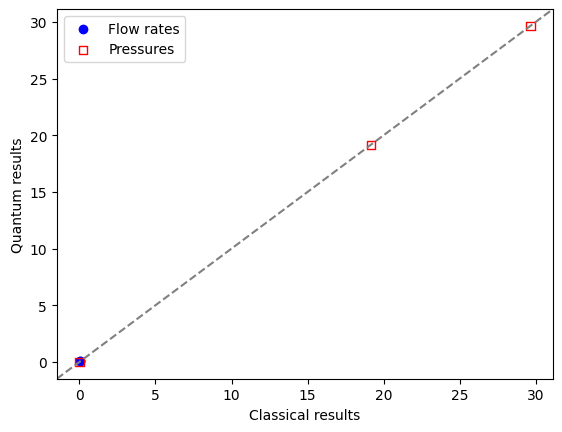

In [8]:
import matplotlib.pyplot as plt

plt.scatter(
    classical_res[:n_pipes],
    quantum_res[:n_pipes],
    label="Flow rates",
    color="blue",
    marker="o",
)
plt.scatter(
    classical_res[n_pipes:],
    quantum_res[n_pipes:],
    label="Pressures",
    color="red",
    marker="s",
    facecolors="none",
)
plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
plt.xlabel("Classical results")
plt.ylabel("Quantum results")
plt.legend()
plt.show()

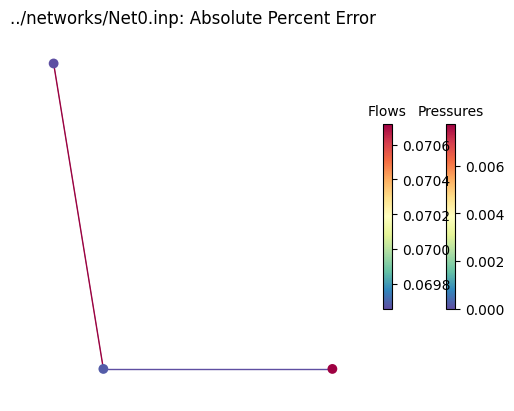

<Axes: title={'center': '../networks/Net0.inp: Absolute Percent Error'}>

In [9]:
from utils import get_ape_from_pd_series

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_hhl.node["pressure"].iloc[0], results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_hhl.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label="Pressures",
    link_colorbar_label="Flows",
    node_size=50,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=False,
)